# Fitting Latest Data and Providing Future Estimates

The following consists of a fit to Danish Covid-19 test data, with the aim of determining most precisely the picture for the coming months time.

The fit determins the parameters of the current situation, that is the number of daily positives $P_i$, which is scaled in relation to the number of daily tests $T_i$ as $(T_i/\bar{T})^{-\gamma}$ where $\gamma \sim 0.5-0.7$ (determined by MeasuringTestScalingExponent.ipynb), as the number of positives does not grow linearly with number of tests. From this fit one can also extract the contact number and possibly changes in it, when restrictions change. Based on the lockdown from the beginning of the year until 8th of February, the fit assumes an unchanged contact number for this period.

The fit model to the Scaled Positives is: $SP(t) = SP(t_0) ~ R^{(t-t_0)/t_G}$, where $t_G = 4.7$ days.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

save_plots = True
fit_to_latest = True

***

# Read the data:

In [2]:
data_posi = pd.read_csv("Data-Epidemiologisk-Rapport/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
data_test = pd.read_csv("Data-Epidemiologisk-Rapport/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

# TP note: The above reads the "municipality data", which we then sum over. It seems that there are slight differences to the "overall" data!
# However, differences are really small, so let us not consider this further for now!

# Print how much data is included:
date_start = "2021-01-01"
if fit_to_latest :
    date_end = data_test.index[-3]   # Omitting the very latest data point (with ~0 statistics)
else :
    date_end = "2021-03-06"          # Value in latest report files
print("  Data used: ", date_start, "-", date_end)    
    
# Number of Positives (P) and Tests (T) for all of Denmark ("all")
P_all = data_posi.loc[date_start:date_end].sum(axis=1)
eP_all = np.sqrt(P_all)
T_all = data_test.loc[date_start:date_end].sum(axis=1)
eT_all = np.sqrt(T_all)



  Data used:  2021-01-01 - 2021-03-08


In [3]:
#Split data into winter vacation in week 7 or in week 8.

#Nordfyn = Nordfyns, og Egedal ikke sikker, så ikke inkluderet. NA heller ikke inkluderet!
W7 = ["Copenhagen","Aarhus","Frederiksberg","Kalundborg","Middelfart","Gentofte","Allerød","Dragør","Helsingør","Hillerød","Rudersdal","Næstved","Esbjerg","Favrskov","Frederikssund","Furesø","Holbæk","Kolding","Odense","Silkeborg","Skanderborg","Vejle","Aabenraa","Ballerup","Faxe","Fredericia","Faaborg-Midtfyn","Gladsaxe","Guldborgsund","Haderslev","Halsnæs","Herlev","Herning","Horsens","Hvidovre","Hørsholm","Lolland","Lyngby-Taarbæk","Nordfyns","Nyborg","Randers","Skive","Slagelse","Sorø","Svendborg","Syddjurs","Sønderborg","Vejen","Viborg","Vordingborg","Billund","Brøndby","Gribskov","Holstebro","Kerteminde","Mariagerfjord","Norddjurs","Odder","Odsherred","Ringkøbing-Skjern","Morsø","Thisted","Tønder","Tårnby","Assens","Fredensborg","Lemvig","Bornholm","Ikast-Brande","Langeland","Ringsted","Struer","Hedensted","Varde","Ærø","Fanø","Samsø"]
W8 = ["Roskilde","Solrød","Aalborg","Vallensbæk","Greve","Hjørring","Køge","Lejre","Rødovre","Stevns","Frederikshavn","Rebild","Vesthimmerlands","Glostrup","Høje-Taastrup","Jammerbugt","Ishøj","Albertslund","Brønderslev","Læsø"]



# Number of Positives (P) and Tests (T) for all of Denmark ("all")
P_W7 = data_posi.loc[date_start:date_end][W7].sum(axis=1)
eP_W7 = np.sqrt(P_W7)
T_W7 = data_test.loc[date_start:date_end][W7].sum(axis=1)
eT_W7 = np.sqrt(T_W7)



P_W8 = data_posi.loc[date_start:date_end][W8].sum(axis=1)
eP_W8 = np.sqrt(P_W8)
T_W8 = data_test.loc[date_start:date_end][W8].sum(axis=1)
eT_W8 = np.sqrt(T_W8)



---

# Scale and correct the data:

### Define the constants to be used:

The generation time is fixed (from other sources), while the power $\gamma$, the weekly correction factor, and the systematic uncertainties are obtained from the script "Measuring Test Scaling Exponent".

* The average time between generations has been estimated to be $t_G = 4.7$ days.
* The power $\gamma$ to be used in the scaling with number of tested is chosen to be $\gamma = -0.6$.
* The (multiplicative) weekly fluctuations are a further correction.
* The (multiplicative) systematic uncertainty to apply in order to get a decent Chi2 is so far zero. 

In [4]:
# Average time between generations (in days):
tG = 4.7

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = -0.56

# Correct for effects of weekdays, corrects from 2nd January forward:
frac = [-0.06712774, -0.06683944, -0.05014257, -0.03242197, -0.00406104, 0.12570817,  0.11575076]
frac_fra_lørdag = np.roll(frac, 5)

# To account for larger uncertainties in positives in data than simply the statistical:
SystError = 0.000  

# Fitting function for fraction B117:
t0_B117fit  = 35.0        # t0 is 2021-02-04
frac_t0     = 0.255       # +- 0.008   
tau_B117    = 12.19       # +- 0.40
factor_B117 = np.e**(tG/tau_B117)     # = 1.47. Thus B117 is a factor 1.47 more infectious

def func_fB117(t, frac_t0, tau) :
    return frac_t0*np.exp((t-t0_B117fit)/tau) / ((1-frac_t0) + frac_t0*np.exp((t-t0_B117fit)/tau))

### Calculated the scaled and corrected number of positives:

In [5]:
# These are also the days where corrections are applied:
Plot_StartDay = 0         # 1st of January 2021
Plot_EndDay   = len(P_all)

# Calculate the Scaled Positives (SP):
nAveDailyTests_all = T_all.mean()
print("Average number of PCR tests: ", nAveDailyTests_all)
fPos_all = P_all / T_all
efPos_all = np.sqrt(fPos_all*(1.0-fPos_all)/T_all + SystError**2)
SP_all  = P_all                                * (T_all / nAveDailyTests_all)**Power
eSP_all = np.sqrt(T_all*fPos_all*(1-fPos_all)) * (T_all / nAveDailyTests_all)**Power

# Calculate the Scaled CORRECTED Positives (SCP), i.e. apply correction for weekdays:
SCP_all = np.zeros_like(SP_all)
eSCP_all = np.zeros_like(eSP_all)
for i,x,dx in zip(np.arange(Plot_StartDay,Plot_StartDay+len(SP_all[Plot_StartDay:Plot_EndDay])),
                  SP_all[Plot_StartDay:Plot_EndDay], eSP_all[Plot_StartDay:Plot_EndDay]) :

    # OK - here seems to be a two day shift, which should NOT be there!!!
    factor = 0.6
    SCP_all[i] = x*(1 - factor * frac_fra_lørdag[i%7])
    eSCP_all[i] = dx*(1 - factor * frac_fra_lørdag[i%7])
    # SCP_all[i] = x*(1+frac[i%7])
    # eSCP_all[i] = dx*(1+frac[i%7])
    
# Print the data used for fits:
print(" Date      Ntest      Nposi (P)    SP         SCP")
for i in range(len(T_all)) :
    print(f"{i+1:4d}   {T_all[i]:10d}  {P_all[i]:8d}    {SP_all[i]:8.0f}   {SCP_all[i]:8.0f}")

Average number of PCR tests:  109511.17910447762
 Date      Ntest      Nposi (P)    SP         SCP
   1        30660      1183        2413       2486
   2        71121      2028        2583       2633
   3        63490      1654        2244       2250
   4       103265      2460        2542       2351
   5       102211      1913        1988       1850
   6        93943      1646        1794       1866
   7        83727      1576        1832       1905
   8        73921      1424        1775       1828
   9        51396      1190        1818       1853
  10        47101       987        1583       1587
  11        79208      1337        1603       1482
  12        83218      1247        1454       1353
  13        76034      1103        1353       1408
  14       103699       998        1029       1070
  15        97469       844         901        928
  16        75591       718         884        901
  17        73624       668         834        836
  18       107818       913       

In [6]:
#For week 7
# Calculate the Scaled Positives (SP):
nAveDailyTests_W7 = T_W7.mean()
print("Average number of PCR tests: ", nAveDailyTests_W7)
fPos_W7 = P_W7 / T_W7
efPos_W7 = np.sqrt(fPos_W7*(1.0-fPos_W7)/T_W7 + SystError**2)
SP_W7  = P_W7                                * (T_W7 / nAveDailyTests_W7)**Power
eSP_W7 = np.sqrt(T_W7*fPos_W7*(1-fPos_W7)) * (T_W7 / nAveDailyTests_W7)**Power


    
# Print the data used for fits:
print(" Date      Ntest      Nposi (P)    SP  ")
for i in range(len(T_W7)) :
    print(f"{i+1:4d}   {T_W7[i]:10d}  {P_W7[i]:8d}    {SP_W7[i]:8.0f} " )

Average number of PCR tests:  89638.92537313433
 Date      Ntest      Nposi (P)    SP  
   1        25532       973        1966 
   2        58028      1648        2102 
   3        52690      1350        1818 
   4        84607      1990        2055 
   5        83764      1548        1608 
   6        76848      1309        1427 
   7        68681      1297        1506 
   8        60386      1151        1436 
   9        42346       956        1455 
  10        38585       794        1273 
  11        65080      1059        1267 
  12        68574      1038        1206 
  13        62345       869        1065 
  14        85418       794         816 
  15        79298       683         732 
  16        61341       574         710 
  17        59986       507         635 
  18        89994       708         706 
  19       100103       727         683 
  20        93996       603         587 
  21       100194       674         633 
  22        89458       535         536 
  23      

In [7]:
#For week 8
# Calculate the Scaled Positives (SP):
nAveDailyTests_W8 = T_W8.mean()
print("Average number of PCR tests: ", nAveDailyTests_W8)
fPos_W8 = P_W8 / T_W8
efPos_W8 = np.sqrt(fPos_W8*(1.0-fPos_W8)/T_W8 + SystError**2)
SP_W8  = P_W8                                * (T_W8 / nAveDailyTests_W8)**Power
eSP_W8 = np.sqrt(T_W8*fPos_W8*(1-fPos_W8)) * (T_W8 / nAveDailyTests_W8)**Power


    
# Print the data used for fits:
print(" Date      Ntest      Nposi (P)    SP ")
for i in range(len(T_W8)) :
    print(f"{i+1:4d}   {T_W8[i]:10d}  {P_W8[i]:8d}    {SP_W8[i]:8.0f} " )

Average number of PCR tests:  18889.253731343284
 Date      Ntest      Nposi (P)    SP 
   1         4891       196         418 
   2        12498       365         460 
   3        10319       288         404 
   4        17807       455         470 
   5        17662       351         364 
   6        16438       322         348 
   7        14502       270         313 
   8        13024       259         319 
   9         8687       226         349 
  10         8155       181         290 
  11        13380       270         328 
  12        13896       203         241 
  13        13129       227         278 
  14        17491       196         205 
  15        17504       152         159 
  16        13614       141         169 
  17        13010       153         189 
  18        16941       194         206 
  19        20154       171         165 
  20        18161       160         164 
  21        21432       173         161 
  22        19538       169         166 
  23      

---

# Fit the data:

### Define plotting and fitting ranges:

Data before 1st of September 2020 seems irrelevant, as the test system and volume was very different, and since the behaviour and test patterns of the population may have changed since then. The typical starting date for plotting is **1st of January 2021**.

In [8]:
Fit_StartDay   = 3         # 4th of January 2021
Fit_EndDay     = len(P_all) - 1                            # Omitting the last day - changable parameter
Fit_EndDayJan  = 31
day1jan        = np.arange(Plot_StartDay, Plot_EndDay)
day1jan_fit    = np.arange(Fit_StartDay,  Fit_EndDay)
day1jan_fitJan = np.arange(Fit_StartDay,  Fit_EndDayJan)   # Fitting only January!
day_extrapol   = np.arange(Fit_EndDay+1,  Fit_EndDay+21)   # We extrapole 21 days into the future (for now)
day_all        = np.arange(Plot_StartDay, Fit_EndDay+21)   # Entire periodd




## Fit the PCR test data (assuming no B117):

In [9]:
# Exponential function with base Rt:
def func_Expo(x, N0, Rt, t0, tG) :
    # NOTE: tG = time_generation, i.e. average time between generations.
    return N0 * Rt**((x-t0)/tG)

# ChiSquare fit model:
def chi2_calc0(N0, Rt, t0, tG) :
    y_fit = func_Expo(day1jan_fitJan, N0, Rt, t0, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDayJan] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDayJan])**2)
    return chi2

minuit0 = Minuit(chi2_calc0, N0=1000.0, Rt=0.8, t0=1.0, fix_t0=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit0.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
N0_fit = minuit0.values['N0'];       sigma_N0_fit = minuit0.errors['N0']
Rt_fit = minuit0.values['Rt'];       sigma_Rt_fit = minuit0.errors['Rt']
t0_fit = minuit0.values['t0'];       sigma_t0_fit = minuit0.errors['t0']
tG_fit = minuit0.values['tG'];       sigma_tG_fit = minuit0.errors['tG']
print(f"  Rt fit = {minuit0.values['Rt']:5.3f} +- {minuit0.errors['Rt']:5.3f}")

# Calcuate fit quality:
Chi2_fit = minuit0.fval       # The Chi2 value
Npoints = len(day1jan_fitJan) # Number of points fitted
Nvar = 2                      # Number of variables (tG is fixed!)
Ndof_fit = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 209                        │         Nfcn = 69 (69 total)         │
│ EDM = 1.03e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  Rt fit = 0.743 +- 0.003
  Prob(Chi2=209.0, Ndof=26) = 0.000


## Fit the PCR test data **including** B117 component:

With two exponentials, the fit expands in complexity. However, the different $R$ values for DK and UK versions are coupled, based on the B117 fit. Furthermore, the normalisations are also related, as we know the fraction of B117, again from the B117 fit.

This is included by multiplying the $R$ value (which is for the DK version) by the known infection factor to B117, and by fixing the ratio of the DK and UK normalisations at $t_0$. We choose $t_0$ to be the 13th of February, since this is one generation after the opening of the schools for 0-4th grade (8th of February).

In [10]:
# Exponential function with base Rt:
def func_DoubleExpo(x, N0, Rt, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit 
    return N0 * ((1.0-FracB117_at_t0) * Rt**((x-t0)/tG) + FracB117_at_t0 * (Rt * factor_B117)**((x-t0)/tG))

# ChiSquare fit model:
def chi2_calc(N0, Rt, t0, tG) :
    y_fit = func_DoubleExpo(day1jan_fitJan, N0, Rt, t0, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDayJan] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDayJan])**2)
    return chi2

minuit2 = Minuit(chi2_calc, N0=400.0, Rt=0.7, t0=t0_B117fit, fix_t0=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit2.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
N0_fit2 = minuit2.values['N0'];       sigma_N0_fit2 = minuit2.errors['N0']
Rt_fit2 = minuit2.values['Rt'];       sigma_Rt_fit2 = minuit2.errors['Rt']
t0_fit2 = minuit2.values['t0'];       sigma_t0_fit2 = minuit2.errors['t0']
#tG_fit2 = minuit2.values['tG'];       sigma_tG_fit2 = minuit2.errors['tG']
print("  N0 fit = ", N0_fit2, "+-", sigma_N0_fit2)
print("  Rt fit = ", Rt_fit2, "+-", sigma_Rt_fit2)
#print("  t0 fit = ", t0_fit2, "+-", sigma_t0_fit2)

# Calcuate fit quality:
Chi2_fit2 = minuit2.fval       # The Chi2 value
Nvar = 2                       # Number of variables (t0 and tG are fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 201.8                      │         Nfcn = 47 (47 total)         │
│ EDM = 2.87e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  N0 fit =  323.2754156627359 +- 5.987183952967308
  Rt fit =  0.7239342456287942 +- 0.0026788859664839924
  Prob(Chi2=201.8, Ndof=26) = 0.000


## Fit the PCR test data with a change in R:

Given a change of $R$ at $t_0$, the fit expands to have at least two $R$ values (before and after $t_0$) and possibly also $t_0$ in itself, if this is to be a floating parameter.

In [11]:
# Exponential function with base Rb (= before t0) and Ra (= after t0):
def func_DoubleExpoStep(x, N0, Rb, Ra, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit 
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    else :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))

func_DoubleExpoStep_vec = np.vectorize(func_DoubleExpoStep)

# ChiSquare fit model:
def chi2_calcStep(N0, Rb, Ra, t0, tG) :
    y_fit = func_DoubleExpoStep_vec(day1jan_fit, N0, Rb, Ra, t0, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDay] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

# The t0 is now just set to the end of the B117-fit... it should of course not be... To Be Changed/Updated!
minuit3 = Minuit(chi2_calcStep, N0=400.0, Rb=0.7, Ra=0.7, t0=t0_B117fit, fix_t0=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit3.migrad();                                                  

# Here we extract the fitting parameters and their errors
N0_fit3 = minuit3.values['N0'];       sigma_N0_fit3 = minuit3.errors['N0']
Rb_fit3 = minuit3.values['Rb'];       sigma_Rb_fit3 = minuit3.errors['Rb']
Ra_fit3 = minuit3.values['Ra'];       sigma_Ra_fit3 = minuit3.errors['Ra']
t0_fit3 = minuit3.values['t0'];       sigma_t0_fit3 = minuit3.errors['t0']
print("  N0 fit = ", N0_fit3, "+-", sigma_N0_fit3)
print("  Rb fit = ", Rb_fit3, "+-", sigma_Rb_fit3)
print("  Ra fit = ", Ra_fit3, "+-", sigma_Ra_fit3)
#print("  t0 fit = ", t0_fit3, "+-", sigma_t0_fit3)

# Calcuate fit quality:
Chi2_fit2 = minuit3.fval       # The Chi2 value
Nvar = 3                       # Number of variables (t0 and tG are fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 677.3                      │        Nfcn = 102 (102 total)        │
│ EDM = 3.24e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  N0 fit =  381.1238856272704 +- 4.291696914318506
  Rb fit =  0.7472025910626278 +- 0.0018983975925895907
  Ra fit =  0.8735313700512212 +- 0.002667260750027074
  Prob(Chi2=677.3, Ndof=25) = 0.000


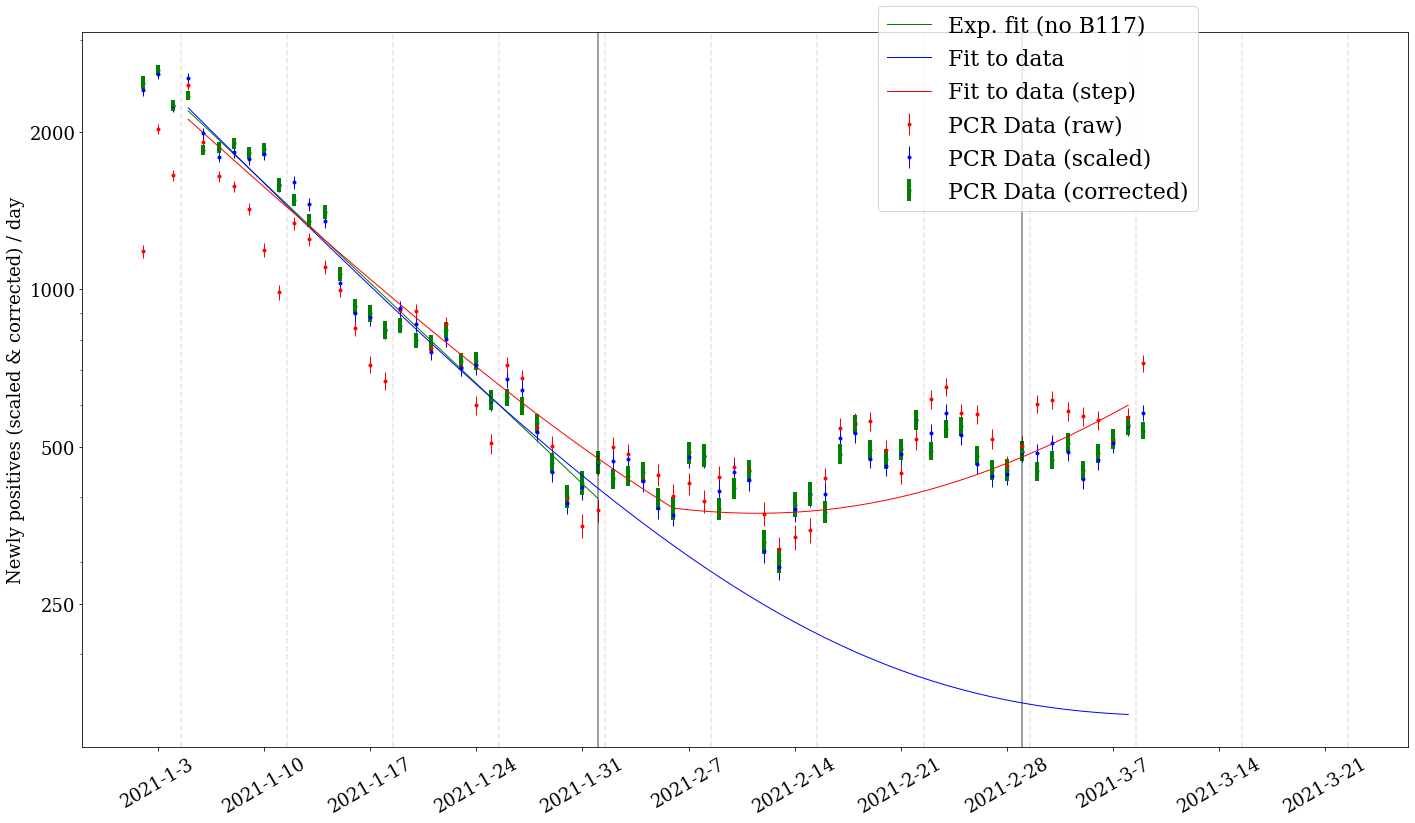

In [12]:
# Put dates on the x-axis:
now = dt.datetime.now()         # Changed to the last date of data?
then = now + dt.timedelta(days=-(Plot_EndDay-Plot_StartDay))
dato_start = "2021-01-01"

fig, ax = plt.subplots(figsize=(20, 12))
ax.set(xlabel="", ylabel="Newly positives (scaled & corrected) / day", title="")
ax.errorbar(day1jan, P_all[Plot_StartDay:Plot_EndDay], yerr=eP_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=1, label='PCR Data (raw)', color='red')
ax.errorbar(day1jan, SP_all[Plot_StartDay:Plot_EndDay], yerr=eSP_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=1, label='PCR Data (scaled)', color='blue')
ax.errorbar(day1jan, SCP_all[Plot_StartDay:Plot_EndDay], yerr=eSCP_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=4, label='PCR Data (corrected)', color='green')

# Plot the fit model on top of data:
ax.plot(day1jan_fitJan, func_Expo(day1jan_fitJan, N0_fit, Rt_fit, t0_fit, tG_fit), 'green', linewidth=1.0, label='Exp. fit (no B117)')
ax.plot(day1jan_fit, func_DoubleExpo(day1jan_fit, N0_fit2, Rt_fit2, t0_fit2, tG), 'blue',  linewidth=1.0, label='Fit to data')
ax.plot(day1jan_fit,  func_DoubleExpoStep_vec(day1jan_fit,  N0_fit3, Rb_fit3, Ra_fit3, t0_fit3, tG), 'red', linewidth=1.0, label='Fit to data (step)')
#ax.plot(day_extrapol, func_DoubleExpo(day_extrapol-len(day1jan_fit), N0_fit2, Rt_fit2, t0_fit2, tG_fit2), 'blue', linewidth=1.0, label='Extrapolation', linestyle="dotted")


# Put nice labels on the original axis:
plt.xticks(ticks=np.arange(1,len(P_all[dato_start:]),7), labels=np.array(P_all[dato_start::7].index), rotation=30)
for x in np.arange(2.5, max(day_extrapol), 7): 
    plt.axvline( x, ls='--', color='grey', alpha=0.2)

times = []; N_weeks = int(max(day_extrapol)/7)
for i in range(N_weeks):
    times.append(then + dt.timedelta(days=7*i))
    
plt.xticks(ticks=[7*i+1 for i in range(N_weeks)], 
           labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times])


# Plot monthly lines on first date:
d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:] ))
for i in range(len(data_posi.loc[date_start:date_end].sum(axis=1))):
    d_now = d_now + dt.timedelta(days=1)
    if d_now.day == 1:
        plt.axvline( i, ls='-', color='k', alpha=0.5)


# Plot the fraction of B117 on secondary y-axis (to the right):
#ax2 = ax.twinx()
#ax2.plot(day_all, func_logistic(day_all-33, *[frac_t0_fit, tau_fit]), color="red", marker="", alpha=0.2)
#ax2.set_ylabel("Fraction B117", color="red", fontsize=22)
#ax2.tick_params(axis='y', colors='red')

plt.yscale("log")
ax.set_yticks([250,500,1000,2000])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend(loc=(0.60, 0.75), fontsize=22)
plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_FitOfPCRdata_WithDKandUKversions.pdf")

In [13]:
# Linear fits to the fraction of week 7 / week 8:

W78_f = SP_W7/SP_W8
eW78_f = np.sqrt((eSP_W7[Plot_StartDay:Plot_EndDay]/SP_W7[Plot_StartDay:Plot_EndDay])**2+(eSP_W8[Plot_StartDay:Plot_EndDay]/SP_W8[Plot_StartDay:Plot_EndDay])**2)

W78_fit1_StartDay = 16
W78_fit1_EndDay = 16+30
W78_fit2_StartDay = 16+30
W78_fit2_EndDay = 16+30+7

day_W78_fit_1 = np.arange(W78_fit1_StartDay,W78_fit1_EndDay)
day_W78_fit_2 = np.arange(W78_fit2_StartDay,W78_fit2_EndDay)



def func_W78_1(x, a) :
    # NOTE: tG = time_generation, i.e. average time between generations.
    return a



# ChiSquare fit model:
def chi2_calc0(a) :
    y_fit = func_W78_1(day_W78_fit_1, a)
    chi2 = np.sum(((W78_f[W78_fit1_StartDay:W78_fit1_EndDay] - y_fit) / eW78_f[W78_fit1_StartDay:W78_fit1_EndDay])**2)
    return chi2

minuit0 = Minuit(chi2_calc0, a=4, print_level=1, errordef=1.0)
minuit0.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
a_fit = minuit0.values['a'];       sigma_a_fit = minuit0.errors['a']

print(f"  a fit = {minuit0.values['a']:5.3f} +- {minuit0.errors['a']:5.3f}")

# Calcuate fit quality:
Chi2_fit = minuit0.fval       # The Chi2 value
Npoints = len(day_W78_fit_1) # Number of points fitted
Nvar = 1                      # Number of variables (tG is fixed!)
Ndof_fit = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")



def func_W78_2(x, a2) :
    # NOTE: tG = time_generation, i.e. average time between generations.
    return a2


# ChiSquare fit model:
def chi2_calc0(a2) :
    y_fit = func_W78_2(day_W78_fit_2, a2)
    chi2 = np.sum(((W78_f[W78_fit2_StartDay:W78_fit2_EndDay] - y_fit) / eW78_f[W78_fit2_StartDay:W78_fit2_EndDay])**2)
    return chi2

minuit0 = Minuit(chi2_calc0, a2=6, print_level=1, errordef=1.0)
minuit0.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
a2_fit = minuit0.values['a2'];       sigma_a2_fit = minuit0.errors['a2']

print(f"  a2 fit = {minuit0.values['a2']:5.3f} +- {minuit0.errors['a2']:5.3f}")

# Calcuate fit quality:
Chi2_fit = minuit0.fval       # The Chi2 value
Npoints = len(day_W78_fit_1) # Number of points fitted
Nvar = 1                      # Number of variables (tG is fixed!)
Ndof_fit = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 549.6                      │         Nfcn = 13 (13 total)         │
│ EDM = 1.09e-15 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  a fit = 3.609 +- 0.019
  Prob(Chi2=549.6, Ndof=29) = 0.000
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 310.9                      │         Nfcn = 13 (13 total)         │
│ EDM = 2.21e-17 (Goal: 0.0

a før uge 7 effekt =  3.6092826421301454 a2 efter uge 7 effekt =  4.955099959070667
Ændring i fraction a2/a =  1.372876676719959 +/-  0.01027486463973261


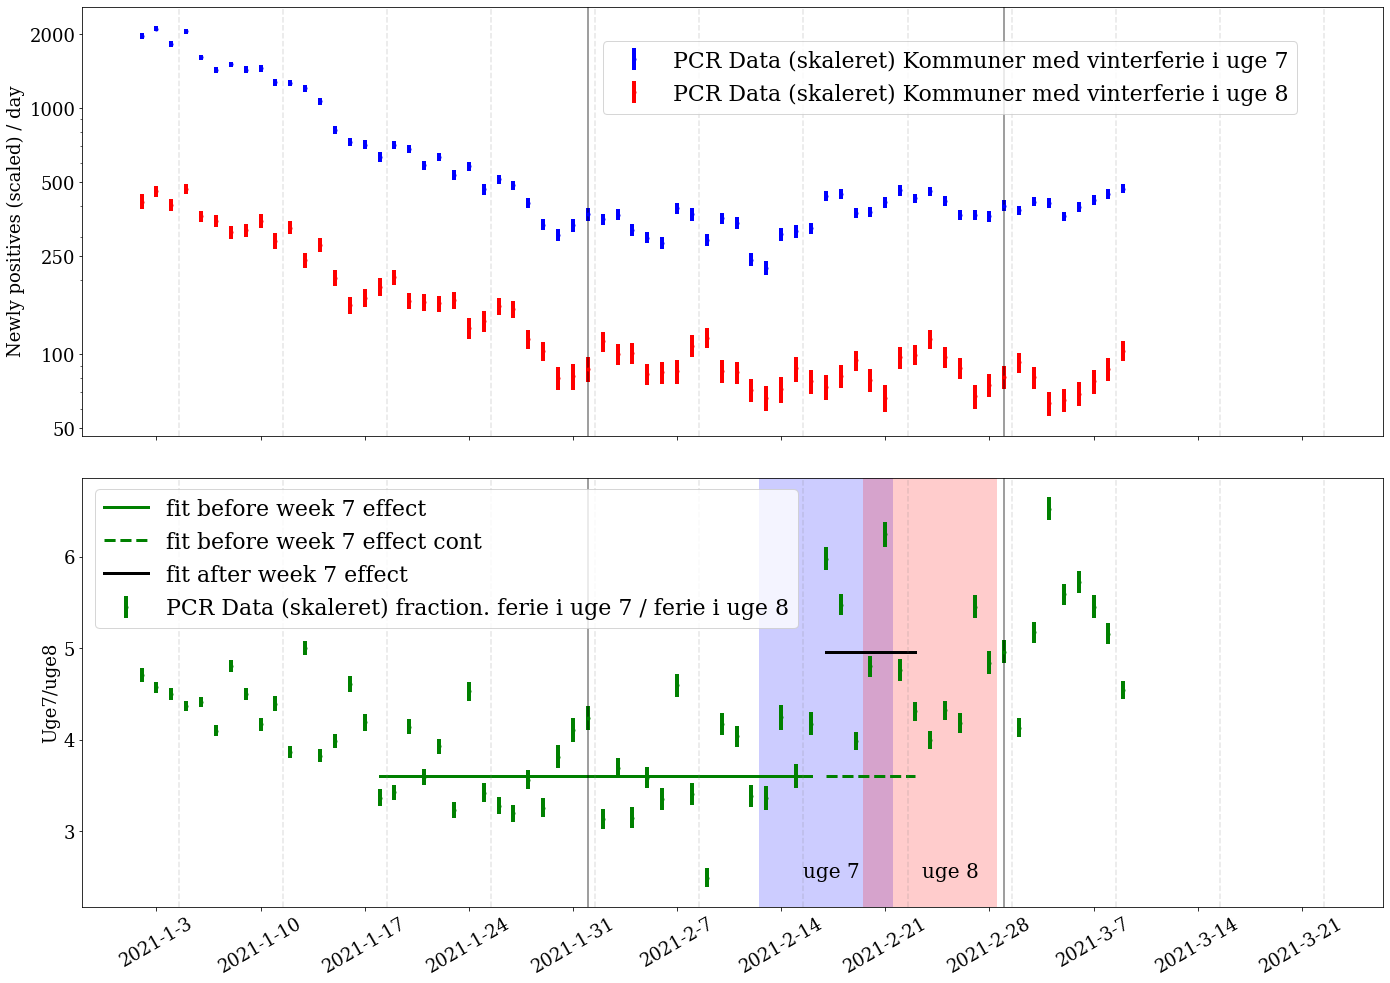

In [14]:
# Plot and analysis for difference between week 7 and 8.

# Put dates on the x-axis:
now = dt.datetime.now()         # Changed to the last date of data?
then = now + dt.timedelta(days=-(Plot_EndDay-Plot_StartDay))
dato_start = "2021-01-01"

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(20, 14),sharex=True)

ax[0].set(xlabel="", ylabel="Newly positives (scaled) / day", title="")

ax[0].errorbar(day1jan, SP_W7[Plot_StartDay:Plot_EndDay], yerr=eSP_W7[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=4, label='PCR Data (skaleret) Kommuner med vinterferie i uge 7', color='blue')
ax[0].errorbar(day1jan, SP_W8[Plot_StartDay:Plot_EndDay], yerr=eSP_W8[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=4, label='PCR Data (skaleret) Kommuner med vinterferie i uge 8', color='red')


ax[1].errorbar(day1jan,W78_f, yerr=eW78_f, fmt='.', linewidth=4, label='PCR Data (skaleret) fraction. ferie i uge 7 / ferie i uge 8', color='green')

# Plot the fit model on top of data:
ax[1].plot(day_W78_fit_1, np.ones_like(day_W78_fit_1)*a_fit, 'green', linewidth=3.0, label='fit before week 7 effect')
ax[1].plot(day_W78_fit_2, np.ones_like(day_W78_fit_2)*a_fit, 'green',linestyle='dashed', linewidth=3.0, label='fit before week 7 effect cont')
ax[1].plot(day_W78_fit_2, np.ones_like(day_W78_fit_2)*a2_fit, 'black', linewidth=3.0, label='fit after week 7 effect')


# Put nice labels on the original axis:
plt.xticks(ticks=np.arange(1,len(P_all[dato_start:]),7), labels=np.array(P_all[dato_start::7].index), rotation=30)
for x in np.arange(2.5, max(day_extrapol), 7): 
    ax[0].axvline( x, ls='--', color='grey', alpha=0.2)
    ax[1].axvline( x, ls='--', color='grey', alpha=0.2)

times = []; N_weeks = int(max(day_extrapol)/7)
for i in range(N_weeks):
    times.append(then + dt.timedelta(days=7*i))
    
plt.xticks(ticks=[7*i+1 for i in range(N_weeks)], 
           labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times])


# Plot monthly lines on first date:
d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:] ))
for i in range(len(data_posi.loc[date_start:date_end].sum(axis=1))):
    d_now = d_now + dt.timedelta(days=1)
    if d_now.day == 1:
        ax[1].axvline( i, ls='-', color='k', alpha=0.5)
        ax[0].axvline( i, ls='-', color='k', alpha=0.5)



ax[0].set_yscale("log")
ax[0].set_yticks([50,100,250,500,1000,2000])
ax[0].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax[1].set(xlabel="", ylabel="Uge7/uge8", title="")

ax[0].legend(loc=(0.4, 0.75), fontsize=22)
ax[1].legend(loc=(0.01, 0.65), fontsize=22)
ax[1].axvspan(41.5, 50.5, facecolor='b', alpha=0.2)
ax[1].axvspan(48.5, 57.5, facecolor='r', alpha=0.2)
ax[1].text(44.5,2.5,'uge 7',fontsize=20)
ax[1].text(52.5,2.5,'uge 8',fontsize=20)

plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_FitOfPCRdata_WithDKandUKversions.pdf")
    
print('a før uge 7 effekt = ',a_fit, 'a2 efter uge 7 effekt = ',a2_fit)
print('Ændring i fraction a2/a = ', a2_fit/a_fit,'+/- ', np.sqrt((sigma_a2_fit/a2_fit)**2 + (sigma_a_fit/a_fit)**2 ))
    

***

# Combination into forecast:

The above two fits makes it possible to forecast the development of the two vira:
- DK version: PCR-fit * (1-frac(t)), up to t0
              PCR-fit * (1-frac(t0), after t0
- UK version: PCR-fit * frac(t), up to t0
              PCR-fit(R*1.45) * frac(t), after t0

In [15]:
"""
fig2, ax2 = plt.subplots(figsize=(15, 8))
ax2.set(xlabel="Days in 2021 (1st of January is day 1)", ylabel="Newly infected / day", title="")

Ndays_offset = 5           # The B.1.1.7 data goes to the 12th, while the PCR goes to the 17th
day1jan_frac = np.arange(-len(day1jan_fit) + Ndays_offset, 0)
dayNjan_future = np.arange(0,Nfuture)

print(day1jan_frac)
print(day1jan)
print(dayNjan_future)

ax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit])),   label='DK - From fit', color="blue")
ax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit]),           label='UK - From fit', color="red")
#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit])), label='DK - Extrapolation', color="blue", linestyle=":")
#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit]),         label='UK - Extrapolation', color="red", linestyle=":")
#ax2.plot(dayNjan_future, fit_exp(np.arange(0,Nfuture), *[frac_t0_fit, tau_fit]), label='DK - Extrapolation', color="blue", linestyle=":")


# Plot an "envelope" of possible predictions:
plt.plot(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
plt.plot(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
plt.fill_between(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), color='blue', alpha=0.3)

# Show estimate of "British take-over":
plt.axhline(y=0.5,  xmin=-Ndays, xmax=Nfuture, color='black', linewidth=2.0, linestyle="dotted")
plt.axvline(x=34.0, ymin=0.0,    ymax=0.5,     color='black', linewidth=2.0, linestyle="dotted")

plt.xlim(-Ndays,Nfuture)
plt.ylabel('Fraction of B.1.1.7', fontsize=22)
plt.xlabel('Dates relative to '+str(dates[-1].day)+'-'+str(dates[-1].month)+'-'+str(dates[-1].year), fontsize=22 )




plt.legend()
plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_Extrapolation.pdf")
"""

'\nfig2, ax2 = plt.subplots(figsize=(15, 8))\nax2.set(xlabel="Days in 2021 (1st of January is day 1)", ylabel="Newly infected / day", title="")\n\nNdays_offset = 5           # The B.1.1.7 data goes to the 12th, while the PCR goes to the 17th\nday1jan_frac = np.arange(-len(day1jan_fit) + Ndays_offset, 0)\ndayNjan_future = np.arange(0,Nfuture)\n\nprint(day1jan_frac)\nprint(day1jan)\nprint(dayNjan_future)\n\nax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit])),   label=\'DK - From fit\', color="blue")\nax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit]),           label=\'UK - From fit\', color="red")\n#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit])), label=\'DK - Extrapolation\', color="blue", lines

In [41]:
alt_W78_fit = np.arange(0, 56) #Do from Jan 1st to 14 days after R is allowed to change for the second time

def func_DoubleExpoStep2(x, N0, Rb, Ra, Rc, t0, t1, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    elif (x < t1) :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))
    else :
        N1 = N0 * ((1.0-FracB117_at_t0) * Ra**((t1-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((t1-t0)/tG))
        return N1 * ((1.0-FracB117_at_t0) * Rc**((x-t1)/tG) + FracB117_at_t0 * (Rc * factor_B117)**((x-t1)/tG))

func_DoubleExpoStep2_vec = np.vectorize(func_DoubleExpoStep2)

# ChiSquare fit model:

def chi2_calcStep2(N0, Rb, Ra, Rc, t0, t1, tG) :
    y_fit = func_DoubleExpoStep2_vec(alt_W78_fit, N0, Rb, Ra, Rc, t0, t1, tG)
    chi2 = np.sum(((SP_W8[0:56] - y_fit) / eSP_W8[0:56])**2)
    return chi2

# The t0 is now just set to the end of the B117-fit... it should of course not be... To Be Changed/Updated!
minuit4 = Minuit(chi2_calcStep2, N0=400.0, Rb=0.7, Ra=0.8, Rc=0.9, t0=27.0, fix_t0=False, t1=42.0, fix_t1=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit4.migrad();                                                  

# Here we extract the fitting parameters and their errors
N0_fit4 = minuit4.values['N0'];       sigma_N0_fit4 = minuit4.errors['N0']
Rb_fit4 = minuit4.values['Rb'];       sigma_Rb_fit4 = minuit4.errors['Rb']
Ra_fit4 = minuit4.values['Ra'];       sigma_Ra_fit4 = minuit4.errors['Ra']
Rc_fit4 = minuit4.values['Rc'];       sigma_Rc_fit4 = minuit4.errors['Rc']
t0_fit4 = minuit4.values['t0'];       sigma_t0_fit4 = minuit4.errors['t0']
t1_fit4 = minuit4.values['t1'];       sigma_t1_fit4 = minuit4.errors['t1']
print("  N0 fit = ", N0_fit4, "+-", sigma_N0_fit4)
print("  Rb fit = ", Rb_fit4, "+-", sigma_Rb_fit4)
print("  Ra fit = ", Ra_fit4, "+-", sigma_Ra_fit4)
print("  Rc fit = ", Rc_fit4, "+-", sigma_Rc_fit4)
print("  t0 fit = ", t0_fit4, "+-", sigma_t0_fit4)
print("  t1 fit = ", t1_fit4, "+-", sigma_t1_fit4)

# Calcuate fit quality:
Chi2_fit2 = minuit4.fval       # The Chi2 value
Nvar = 3                       # Number of variables (tG is fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")



┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 137.8                      │        Nfcn = 420 (420 total)        │
│ EDM = 1.32e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  N0 fit =  100.98907979101024 +- 2.667038378010354
  Rb fit =  0.7446490564889431 +- 0.004843036738286779
  Ra fit =  0.7920681684568612 +- 0.014493784457018998
  Rc fit =  0.9362526349708465 +- 0.024112845311248066
  t0 fit =  28.99979251

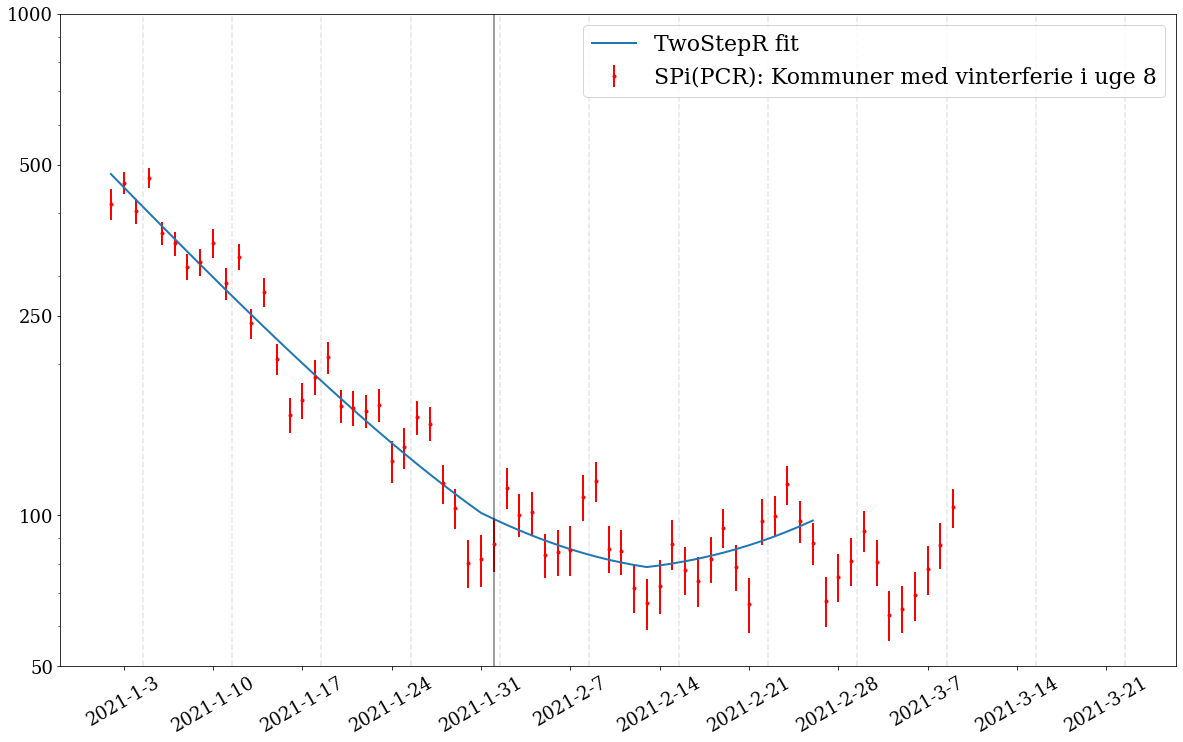

In [45]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(alt_W78_fit, func_DoubleExpoStep2_vec(alt_W78_fit, N0_fit4, Rb_fit4, Ra_fit4, Rc_fit4,t0_fit4, t1_fit4, tG), linewidth=2, label="TwoStepR fit")
ax.errorbar(day1jan, SP_W8[Plot_StartDay:Plot_EndDay], yerr=eSP_W8[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=2, label='SPi(PCR): Kommuner med vinterferie i uge 8', color='red')
ax.legend(loc="best", fontsize=22)
ax.set_yscale('log')
ax.set_yticks([50,100,250,500,1000])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:] ))
for i in range(len(data_posi.loc["2021-01-01":"2021-02-25"].sum(axis=1))):
    d_now = d_now + dt.timedelta(days=1)
    if d_now.day == 1:
        ax.axvline( i, ls='-', color='k', alpha=0.5)
        
        
times = []; N_weeks = int(max(day_extrapol)/7)
for i in range(N_weeks):
    times.append(then + dt.timedelta(days=7*i))

plt.xticks(ticks=np.arange(1,len(P_all[dato_start:]),7), labels=np.array(P_all[dato_start::7].index), rotation=30)
for x in np.arange(2.5, max(day_extrapol), 7): 
    ax.axvline( x, ls='--', color='grey', alpha=0.2)    

plt.xticks(ticks=[7*i+1 for i in range(N_weeks)], 
           labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times])

plt.show()